https://github.com/SehajS/cnn-resnet-fruit-classification

# Classifying Fruits from their Images

This project aims at creating a deep learning model which predicts the names of the fruits by looking at their images.

The dataset is taken from kaggle and can be accessed using this link: https://www.kaggle.com/moltean/fruits

A complete walkthrough from downloading the dataset to the creating the CNN-ResNet model with extensive comments has been provided.

## Import all the requried libraries/modules

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import os
import shutil
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Downloading the dataset

In [3]:
dataset_url = "https://www.kaggle.com/moltean/fruits"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bhpark00
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/moltean/fruits


100%|██████████| 1.28G/1.28G [00:13<00:00, 100MB/s]


## Cleaning the downloaded dataset

In [4]:
data_direc = '/content/fruits/fruits-360_dataset/fruits-360'
os.listdir(data_direc)

['papers', 'test-multiple_fruits', 'Test', 'Training', 'LICENSE', 'readme.md']

There are some files that one won't be needing in the project. Hence, one should remove them.

In [5]:
shutil.rmtree('/content/fruits/fruits-360_dataset/fruits-360/test-multiple_fruits')

In [6]:
shutil.rmtree('/content/fruits/fruits-360_dataset/fruits-360/papers')

In [7]:
train_data_direc = data_direc + '/Training'
test_data_direc = data_direc + '/Test'

## Import the Dataset using PyTorch

In [8]:
print(f'The total number of labels is: {len(os.listdir(train_data_direc))}')

The total number of labels is: 131


In [9]:
dataset = ImageFolder(train_data_direc)
len(dataset)

67692

In total, there are 67692 non-test images in our dataset.

Let us peek at one of the elements of the dataset. This gives further insights on the way data is stored.

In [10]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=100x100>, 0)

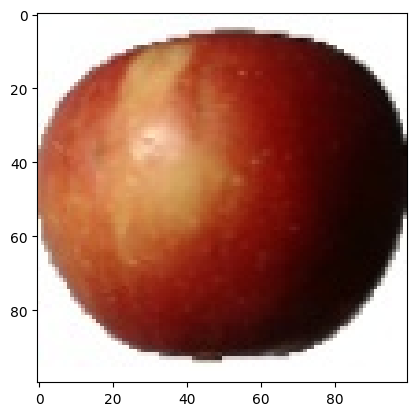

In [11]:
img, label = dataset[0]
plt.imshow(img)

One would now like to convert the images to tensors.

In [12]:
dataset = ImageFolder(train_data_direc, tt.ToTensor())

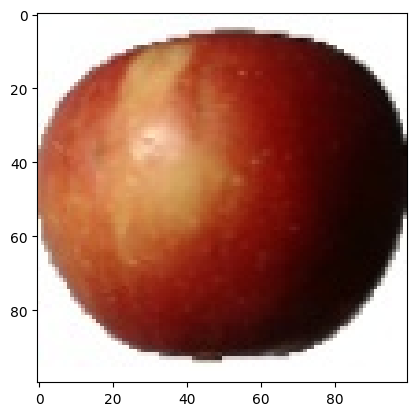

In [13]:
image, label = dataset[0]
plt.imshow(image.permute(1,2,0))

## Training and Validation Sets

In [14]:
val_pct = 0.1        # 10% of the images in Train folder will be used as validation set
val_size = int(len(dataset) * 0.1)
train_size = len(dataset) - val_size
val_size, train_size

(6769, 60923)

In [15]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [16]:
len(train_ds), len(val_ds)

(60923, 6769)

It is time to use Data Loaders to load the dataset in batches.

In [17]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers = 4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


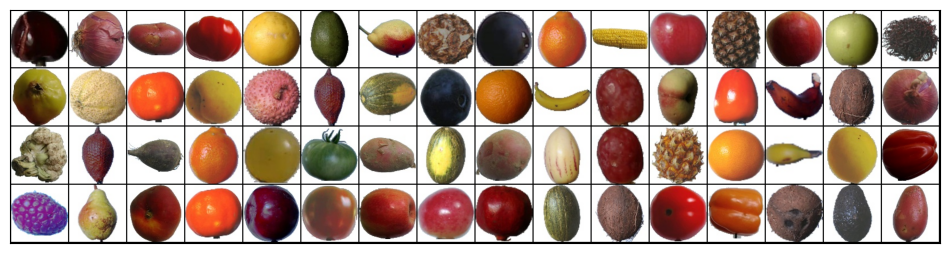

In [19]:
show_batch(train_dl)

## Utility Functions and Classes

The creation and training of the model is done using GPU. Below are the functions that make sure that tensors and the model is using a GPU as the default device.

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model and Training Utilities

In [23]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [26]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [27]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr


Pass one batch of input tensor through the model.


In [28]:
torch.cuda.empty_cache()

for batch in train_dl:
    images, labels = batch
    print('images.shape: ', images.shape)
    print('images.device: ', images.device)
    preds = model(images)
    print('preds.shape: ', preds.shape)
    break

images.shape:  torch.Size([64, 3, 100, 100])
images.device:  cuda:0
preds.shape:  torch.Size([64, 131])


## Training the Model

In [29]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 4.8757219314575195, 'val_acc': 0.006485849153250456}]

Let us train for 5 epochs with the learning rate of 0.001. Note that we use Adam as the optimizer of choice.

In [30]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4932, val_loss: 0.0507, val_acc: 0.9876
Epoch [1], train_loss: 0.0529, val_loss: 0.2423, val_acc: 0.9213
Epoch [2], train_loss: 0.0410, val_loss: 0.0435, val_acc: 0.9860
Epoch [3], train_loss: 0.0212, val_loss: 0.0817, val_acc: 0.9716
Epoch [4], train_loss: 0.0314, val_loss: 0.0821, val_acc: 0.9778


The accuracy achieved on teh valiation set is very high and close to 100%, therefore, one should not train the model for any more epochs. We end the training at 5 epochs.

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

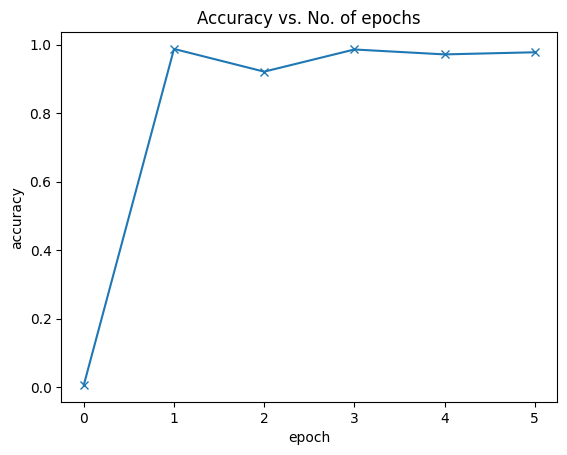

In [32]:
plot_accuracies(history)

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

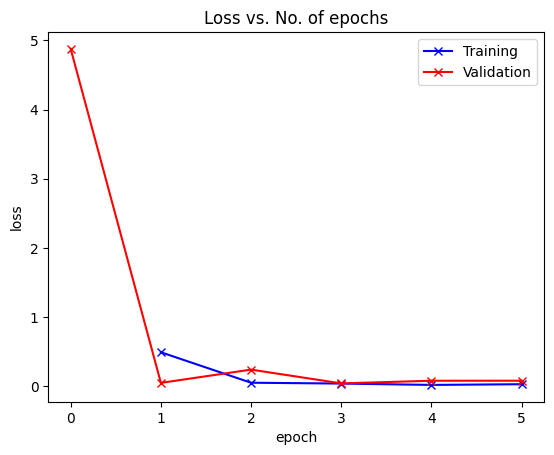

In [34]:
plot_losses(history)

## Testing with Individual Images

Now, one would like to test outthe model that we have built in previous section on the Test dataset and see how it performs.

In [35]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [36]:
test_dataset = ImageFolder(test_data_direc, tt.ToTensor())

In [37]:
len(test_dataset)

22688

In [38]:
def get_prediction(torch_ds, model):
    img, label = torch_ds
    plt.imshow(img.permute(1, 2, 0))
    print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple Braeburn , Predicted: Apple Braeburn


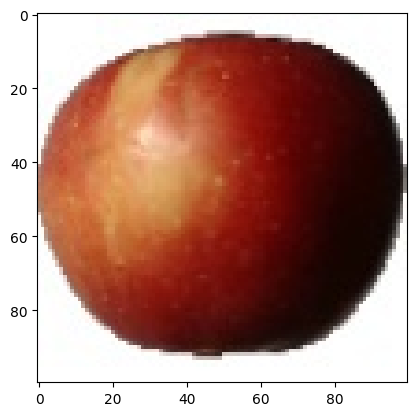

In [39]:
get_prediction(test_dataset[0], model)

Label: Watermelon , Predicted: Watermelon


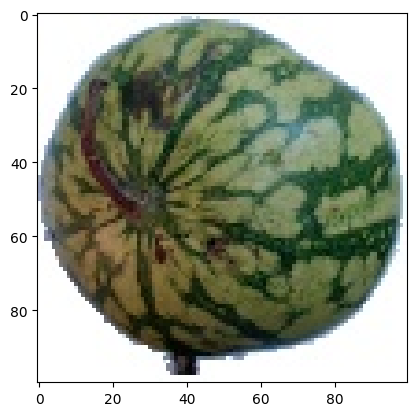

In [40]:
get_prediction(test_dataset[-1], model)

Label: Apple Pink Lady , Predicted: Apple Pink Lady


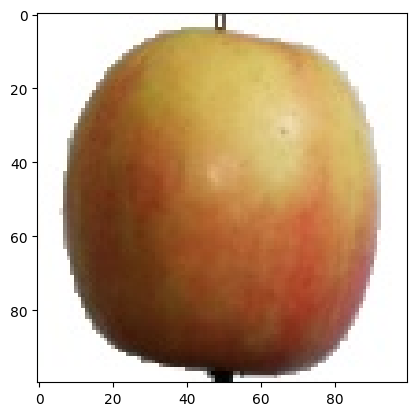

In [41]:
get_prediction(test_dataset[999], model)

In [42]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.18638154864311218, 'val_acc': 0.954353928565979}

Therefore, the accuracy of the model on the test set is little above 98% which is great.

Naturally, a curious mind would like to know for which items did the model perform the worst.

In [43]:
wrong_preds = []
for test_ds in test_dataset:
    img, label = test_ds
    prediction = predict_image(img, model)
    if dataset.classes[label] != prediction:
        wrong_preds.append([dataset.classes[label], prediction])

In [44]:
print(f'Therefore, there are in total {len(wrong_preds)} out of {len(test_dataset)} items in the test set for which the model has made a wrong prediction')

Therefore, there are in total 1040 out of 22688 items in the test set for which the model has made a wrong prediction


In [46]:
len(wrong_preds)

1040

Let us check what did our model predict for each of the wrongly predicted items.

In [47]:
checked = []
for item in wrong_preds:
    if item not in checked:
        checked.append(item)
        print(f'{item[0]} has been wrongfully predicted as {item[1]}')

Apple Braeburn has been wrongfully predicted as Apple Red 2
Apple Crimson Snow has been wrongfully predicted as Apple Pink Lady
Apple Crimson Snow has been wrongfully predicted as Mango Red
Beetroot has been wrongfully predicted as Kohlrabi
Beetroot has been wrongfully predicted as Pear Stone
Beetroot has been wrongfully predicted as Pineapple
Beetroot has been wrongfully predicted as Pear Forelle
Beetroot has been wrongfully predicted as Rambutan
Beetroot has been wrongfully predicted as Potato Sweet
Cantaloupe 2 has been wrongfully predicted as Physalis with Husk
Carambula has been wrongfully predicted as Banana Lady Finger
Carambula has been wrongfully predicted as Cactus fruit
Clementine has been wrongfully predicted as Kaki
Corn has been wrongfully predicted as Physalis with Husk
Corn Husk has been wrongfully predicted as Pear Stone
Corn Husk has been wrongfully predicted as Grape White
Corn Husk has been wrongfully predicted as Watermelon
Cucumber Ripe 2 has been wrongfully predi

## Saving the Model

In [48]:
torch.save(model.state_dict(), 'fruit-prediction.pth')